In [10]:
import dask_awkward as dak
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt
"""
testing for any difference between using OmegaConfig's parameters.yaml vs older parameters.json file
There shouldn't be any differences, but first time using OmegaConfig, so doesn't hurt to check
"""
sample = "dy_M-100To200"

full_load_path = f"/depot/cms/users/yun79/results/stage1/yaml_test/pu_notOnTheSpot/2018/f1_0/{sample}/*/*.parquet"
df_notOnTheSpot = dak.from_parquet(full_load_path) 

full_load_path = f"/depot/cms/users/yun79/results/stage1/yaml_test/pu_OnTheSpot/2018/f1_0/{sample}/*/*.parquet"
df_onTheSpot = dak.from_parquet(full_load_path) 

# using pre-exisitng code for quick validation
df_new=df_notOnTheSpot
df_old=df_onTheSpot

In [11]:
region = df_new.h_sidebands | df_new.h_peak | df_new.z_peak
weights_new = df_new["weights"]
weights_new = weights_new[region].compute()
# weights_new = df_new["weights"].compute()
# if "ggh" in sample:
#     print("ggh in sample!")
#     nnlops_full_load_path = f'/depot/cms/users/yun79/results/stage1/test_full2/2018/f1_0/{sample}/0/nnlops/wgt.parquet'
#     nnlops_wgts = ak.from_parquet(nnlops_full_load_path)["nnlops_wgt"]
#     weights_new = weights_new*nnlops_wgts

#-------------------------------------------------------------------------
print(f"weights_new: {ak.to_numpy(weights_new)}")
print(ak.num(weights_new, axis=0))
region = df_old.h_sidebands | df_old.h_peak | df_old.z_peak
weights_old = df_old["weights"]
weights_old = weights_old[region].compute()
print(f"weights_old: {weights_old}")
print(ak.num(weights_old, axis=0))
print(max(weights_new))
print(min(weights_new))
print(max(weights_old))
print(min(weights_old))
print(max(abs(weights_new[:]-weights_old)/weights_old))
print(np.mean(abs(weights_new[:]-weights_old)))
print(np.median(abs(weights_new[:]-weights_old)))
# print(max(abs(weights_new[:-3]-weights_old)/weights_old))
# print(np.mean(abs(weights_new[:-3]-weights_old)/weights_old))
# print(np.median(abs(weights_new[:-3]-weights_old)/weights_old))
# print(max(abs(weights_new-weights_old[:-3])/weights_old[:-3]))
# print(np.mean(abs(weights_new-weights_old[:-3])/weights_old[:-3]))
# print(np.median(abs(weights_new-weights_old[:-3])/weights_old[:-3]))
# print(max(abs(weights_new-weights_old)/weights_old))
# print(np.mean(abs(weights_new-weights_old)/weights_old))

weights_new: [ 2204.28167224 -1294.85473039  1552.72980203 ...  1975.92218644
 -1420.49121105  2497.53061665]
1063
weights_old: [2.45e+03, -1.2e+03, 1.72e+03, 1.78e+03, ..., 2.08e+03, -1.28e+03, 2.55e+03]
1063
6717.179028720576
-8262.822940812091
6884.374530378587
-8019.769382783768
1.1428857534422756
96.13561715011376
70.89054964146726


In [12]:
binning_map = {
    "pt" : [25, 300, 50],
    "eta" : [-5, 5, 30],
    "phi" : [-3.1415, 3.1415, 101],
    "mass" : [0, 150, 100],
}

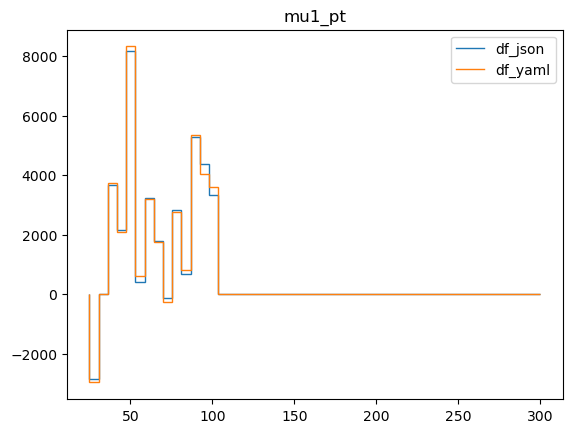

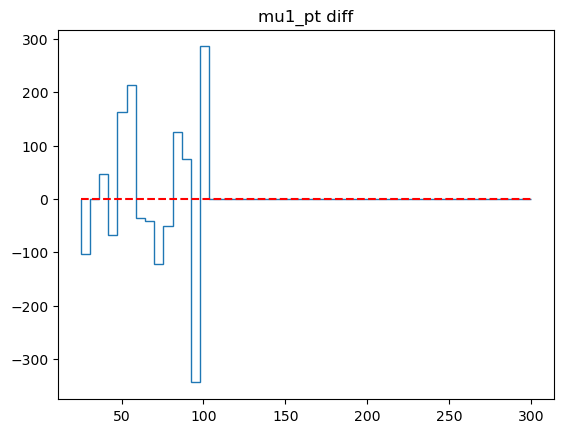

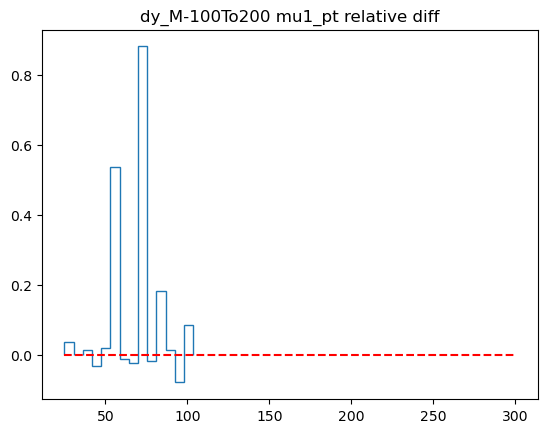

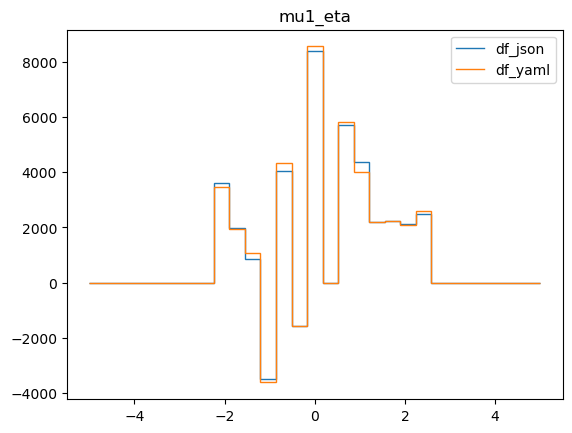

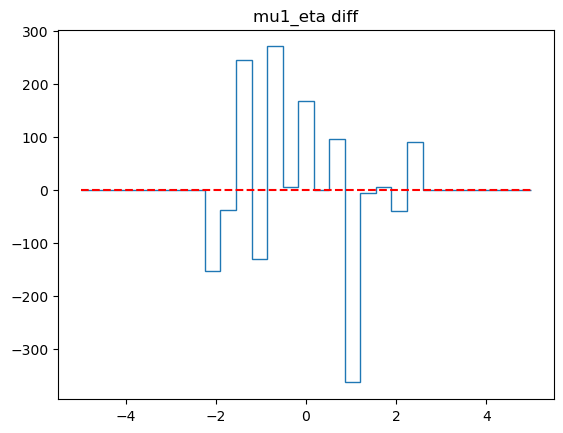

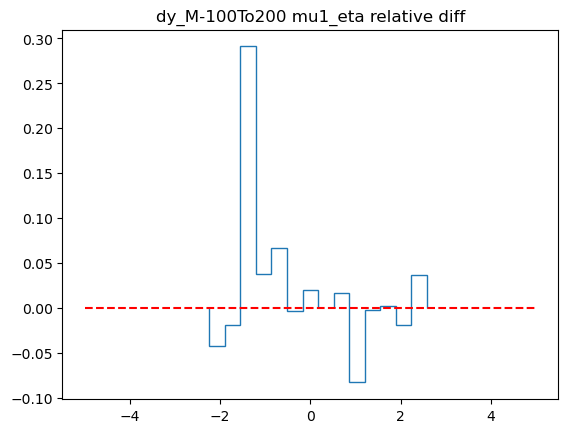

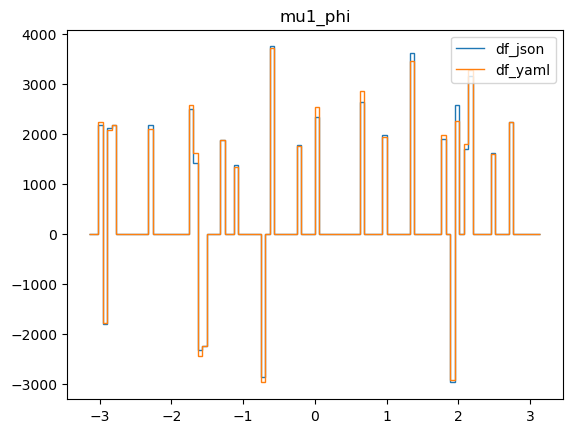

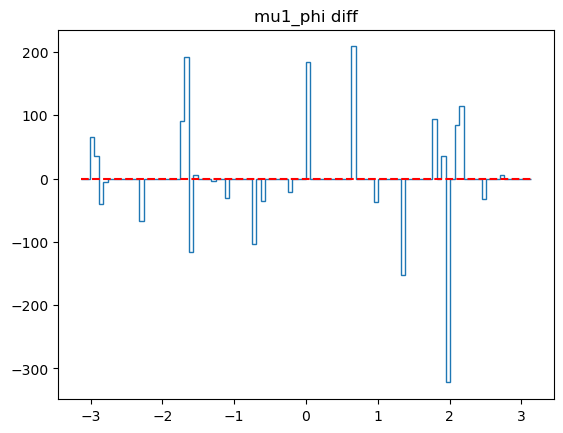

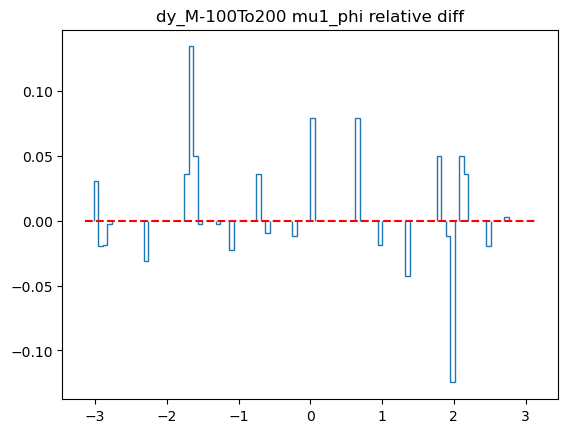

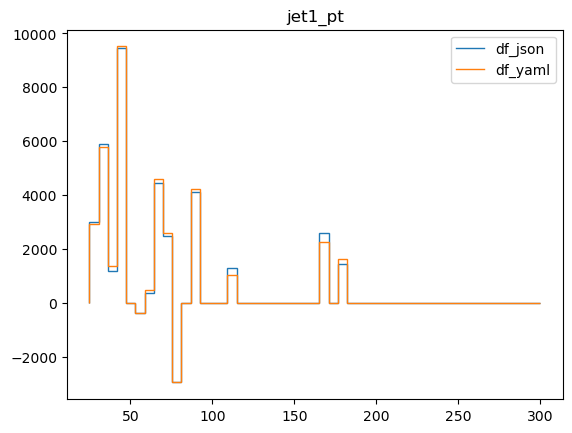

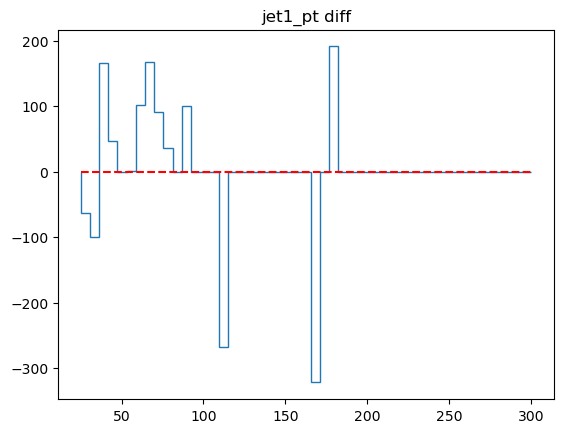

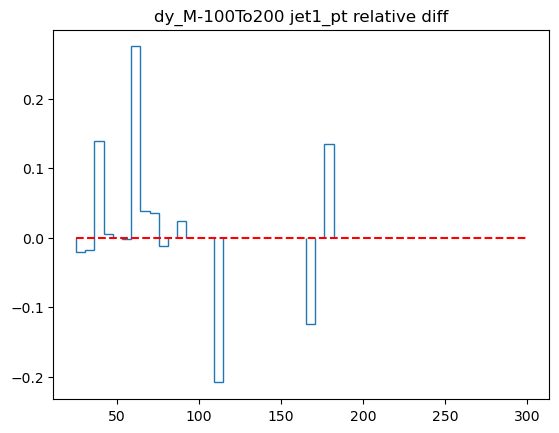

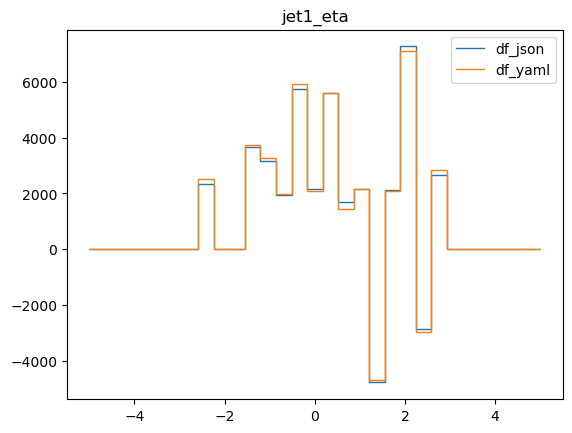

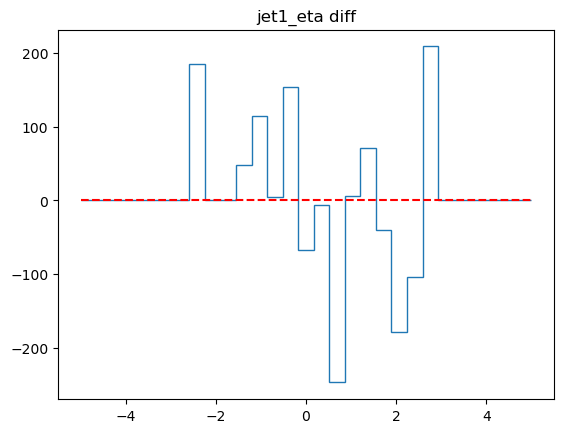

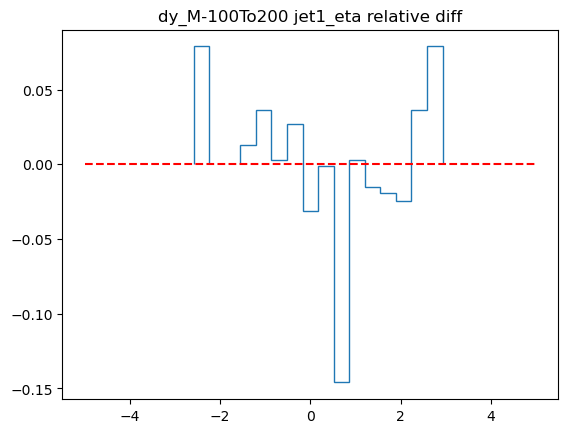

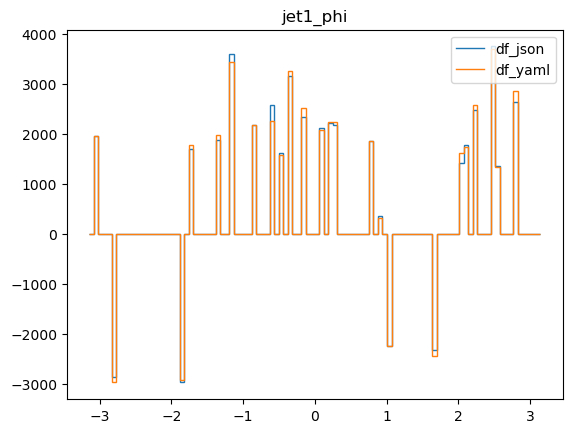

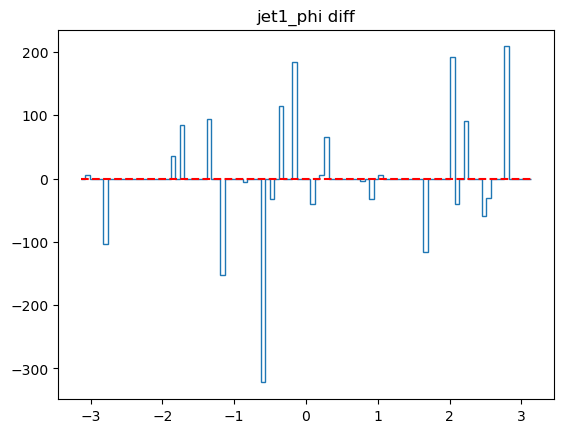

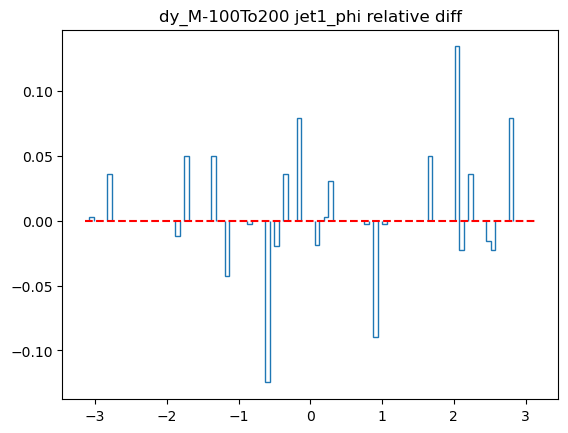

In [13]:
# var = "mu1_pt"
# var = "dimuon_mass"
# var = "jet1_pt"
# variables = ["mu1_pt", "mu2_pt", "dimuon_mass"]
variables = ["mu1_pt","mu1_eta", "mu1_phi", 
             # "jet1_mass", 
             "jet1_pt", "jet1_eta", "jet1_phi"
            ]



# weights_new = ak.to_numpy(df_new["weights"].compute())
region = df_new.h_sidebands | df_new.h_peak | df_new.z_peak
weights_new = df_new["weights"]
btag_cut_new =(df_new["nBtagLoose"] >= 2) | (df_new["nBtagMedium"] >= 1)
weights_new = (weights_new*region * (~df_new["vbf_cut"]) * btag_cut_new).compute()


region = df_old.h_sidebands | df_old.h_peak | df_old.z_peak
weights_old = df_old["weights"]
btag_cut_old =(df_old["nBtagLoose"] >= 2) | (df_old["nBtagMedium"] >= 1)
weights_old = (weights_old*region * (~df_old["vbf_cut"]) * btag_cut_old).compute()

for var in variables:
    kin = var.split("_")[-1]
    # binning = np.linspace(*[25, 300, 50])
    binning = np.linspace(*binning_map[kin])
    # old_len = ak.num(df_old["mu1_pt"].compute(), axis=0)
    # new_len = ak.num(df_new["mu1_pt"].compute(), axis=0)
    # new_weights = np.ones(new_len)
    # new_weights = new_weights*old_len/new_len

    var_old = var
    hist_old, edges = np.histogram(df_old[var_old].compute(), bins=binning ,weights=weights_old)
    # hist_old, edges = np.histogram(df_old[var+"_nominal"].compute(), bins=binning )
    
    # hist_new, _= np.histogram(df_new[region_cut][var].compute(), bins=binning , weights=new_weights)
    hist_new, _= np.histogram(df_new[var].compute(), bins=binning ,weights=weights_new)
    
    plt.stairs(hist_old, edges, label = "df_json")
    plt.stairs(hist_new, edges, label = "df_yaml")
    plt.legend(loc="upper right")
    plt.title(var)
    plt.show()
    plt.stairs((hist_new-hist_old), edges)
    plt.title(var+" diff")
    plt.hlines(0, min(edges), max(edges), colors='red', linestyles="dashed")
    plt.show()
    plt.stairs((hist_new-hist_old)/hist_old, edges)
    plt.title(f"{sample} {var}"+" relative diff")
    plt.hlines(0, min(edges), max(edges), colors='red', linestyles="dashed")
    plt.show()

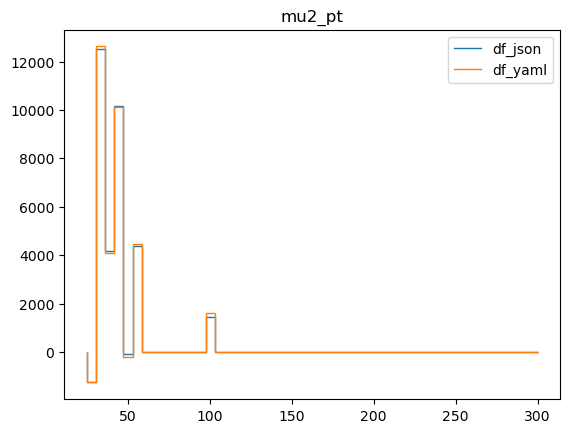

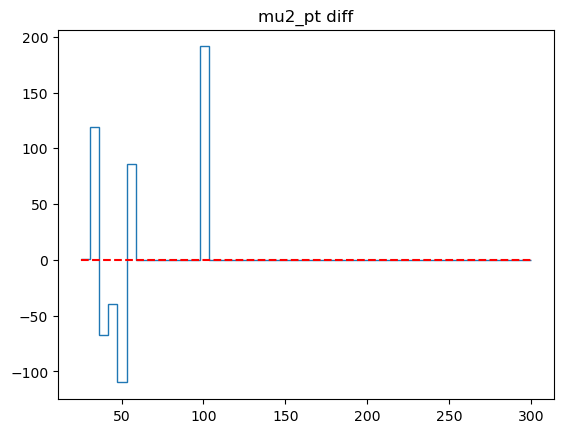

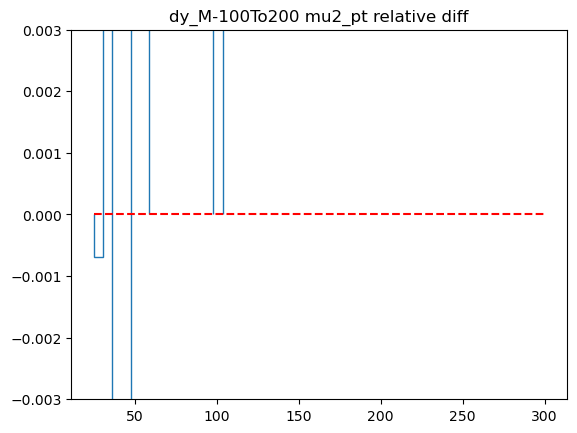

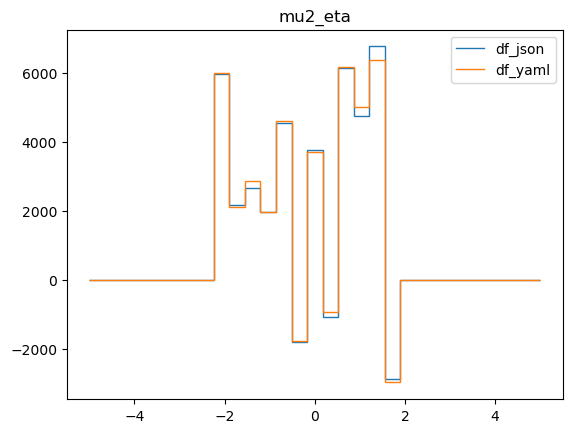

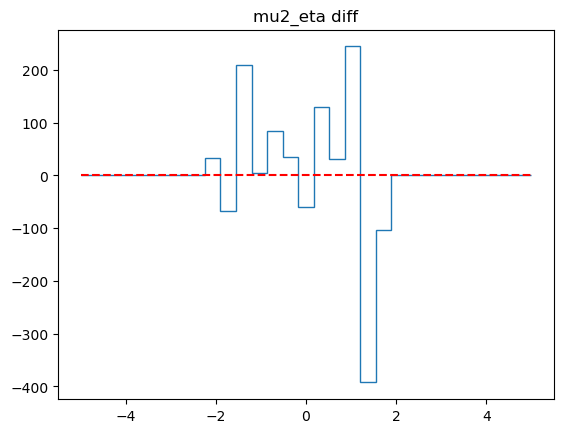

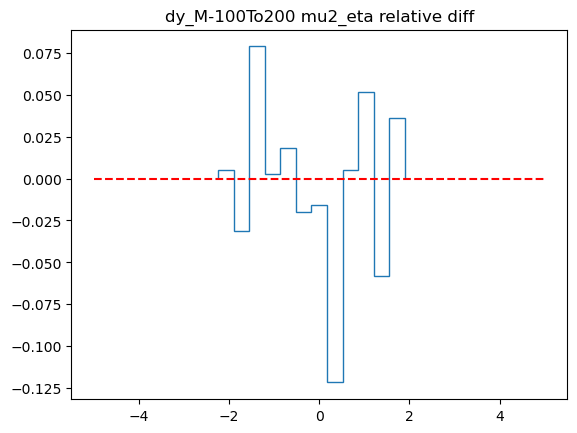

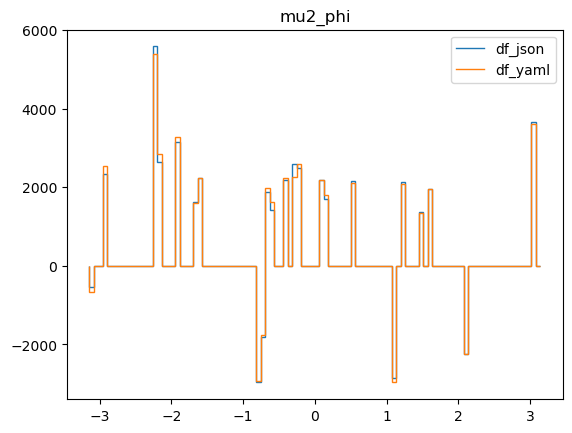

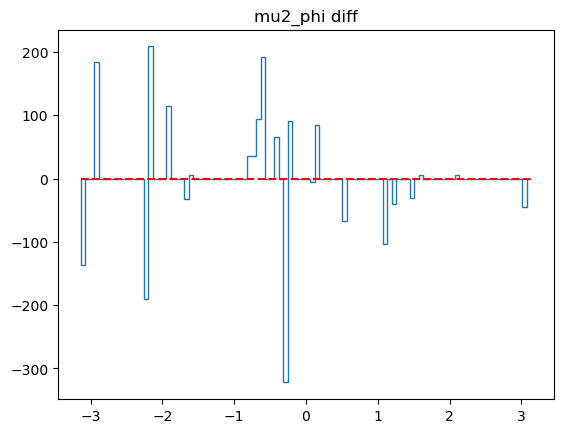

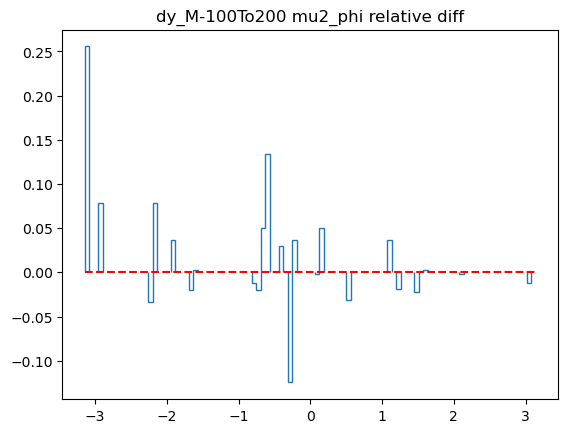

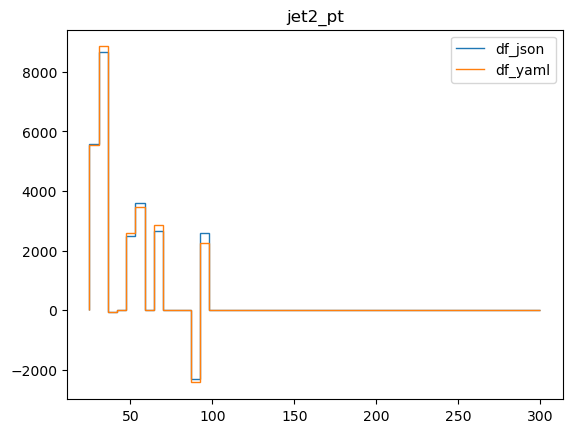

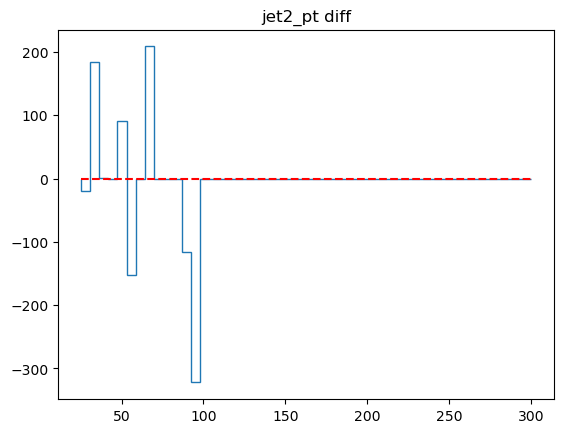

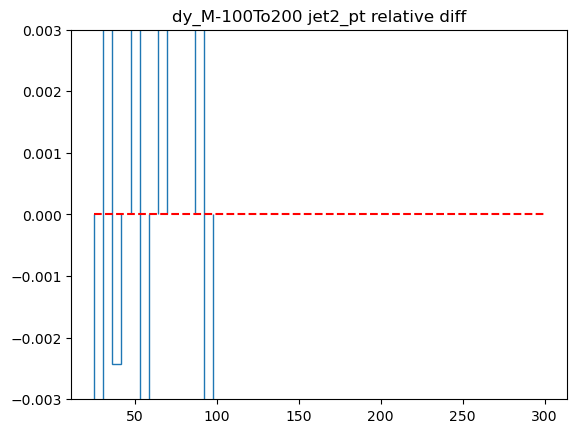

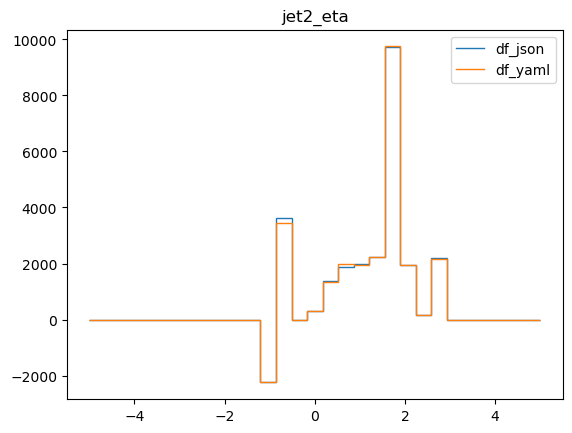

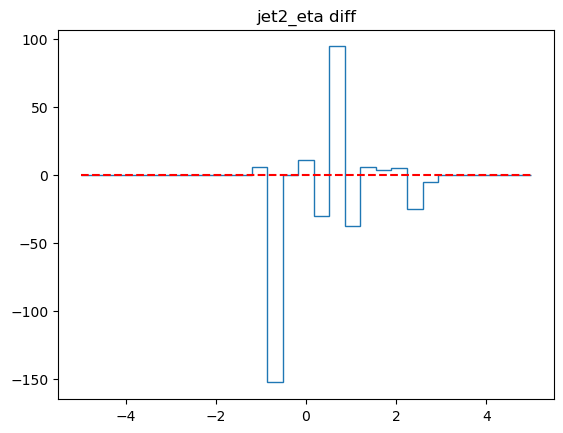

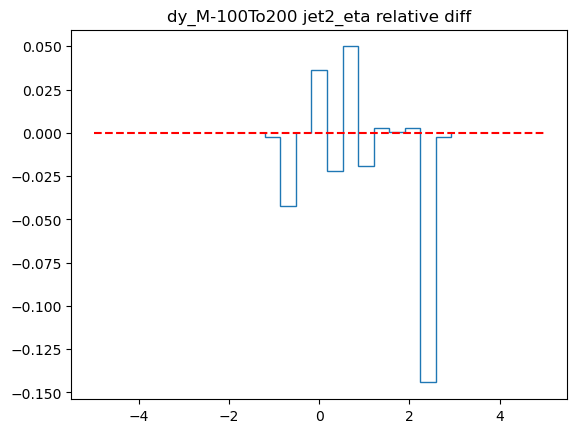

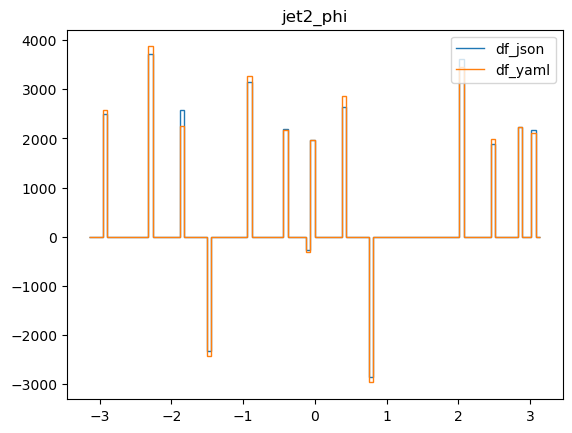

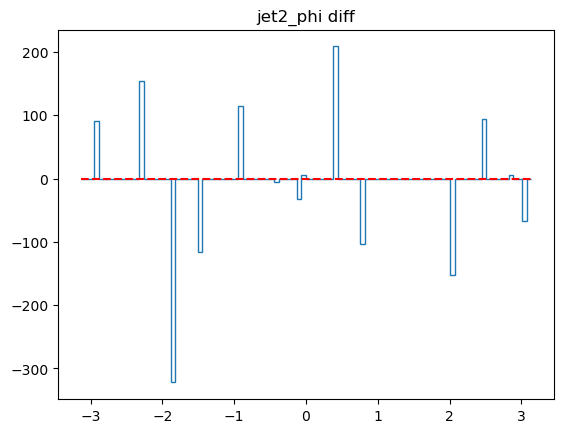

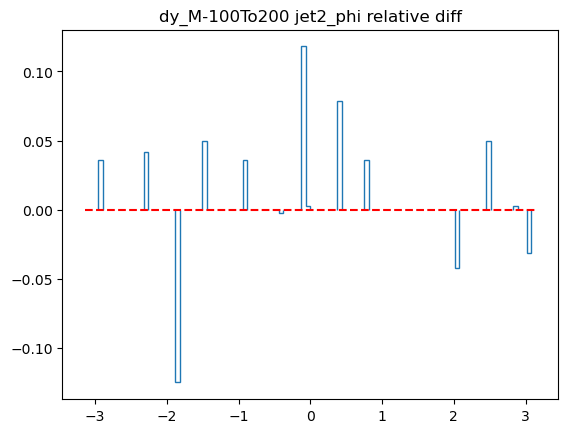

In [14]:
"""
For mu2, special condition is needed bc when there's only one muon, mu2==mu1 in copperhead
"""
# var = "mu1_pt"
# var = "dimuon_mass"
# var = "jet1_pt"
# variables = ["mu1_pt", "mu2_pt", "dimuon_mass"]
variables = ["mu2_pt","mu2_eta", "mu2_phi", 
             # "jet2_mass", 
             "jet2_pt", "jet2_eta", "jet2_phi",
            ]
region = df_new.h_sidebands | df_new.h_peak | df_new.z_peak
weights_new = df_new["weights"]
btag_cut_new =(df_new["nBtagLoose"] >= 2) | (df_new["nBtagMedium"] >= 1)
weights_new = (weights_new*region * (~df_new["vbf_cut"]) * btag_cut_new).compute()


region = df_old.h_sidebands | df_old.h_peak | df_old.z_peak
weights_old = df_old["weights"]
btag_cut_old =(df_old["nBtagLoose"] >= 2) | (df_old["nBtagMedium"] >= 1)
weights_old = (weights_old*region * (~df_old["vbf_cut"]) * btag_cut_old).compute()

for var in variables:
    kin = var.split("_")[-1]
    # binning = np.linspace(*[25, 300, 50])
    binning = np.linspace(*binning_map[kin])

    var_old = var
    hist_old, edges = np.histogram(df_old[var_old].compute(), bins=binning , weights=weights_old)
    hist_new, _= np.histogram(df_new[var].compute(), bins=binning , weights=weights_new)
    
    
    plt.stairs(hist_old, edges, label = "df_json")
    plt.stairs(hist_new, edges, label = "df_yaml")
    plt.legend(loc="upper right")
    plt.title(var)
    plt.show()
    plt.stairs((hist_new-hist_old), edges)
    plt.title(var+" diff")
    plt.hlines(0, min(edges), max(edges), colors='red', linestyles="dashed")
    plt.show()
    plt.stairs((hist_new-hist_old)/hist_old, edges)
    if "pt" in var:
        plt.ylim(-0.003, 0.003)
    plt.title(f"{sample} {var}"+" relative diff")
    plt.hlines(0, min(edges), max(edges), colors='red', linestyles="dashed")
    plt.show()